# Wasserstein GAN

Wasserstein GAN是GAN的变种。JS散度的问题在于当分布$P$和$Q$没有重叠或重叠很小时，会导致损失函数退化的现象。因此，Wasserstein GAN提出了使用Wasserstein距离来衡量生成分布和真实分布之间的差异。

Wasserstein距离衡量从一个分布的分布函数变换到另一个分布的分布函数的最小成本。设$P$和$Q$时定义在$\mathbb{R}^n$上的两个分布，$P$和$Q$的分布函数分别为$P(x)$和$Q(x)$，则Wasserstein距离定义为：

$$
W_p(P, Q) = \inf_{\gamma \in \Pi(P, Q)} \mathbb{E}_{(x, y) \sim \gamma} \Vert x - y\Vert_p
$$

其中$\Vert\cdot\Vert_p$为$p$-范数，$\Pi(P, Q)$为$\mathbb{R}^n \times \mathbb{R}^n$上的分布，并且满足$\Pi(P, Q)$的边缘分布分别为$P$和$Q$。

对于正态分布，Wasserstein距离有解析解。设$P = \mathcal{N}(\mu_1, \Sigma_1)$和$Q = \mathcal{N}(\mu_2, \Sigma_2)$，则2阶范数定义的Wasserstein距离为：

$$
W_2(P, Q) = \Vert \mu_1 - \mu_2 \Vert + \sqrt{\text{tr}\left(\Sigma_1 + \Sigma_2 - 2\left(\Sigma_2^{1/2}\Sigma_1\Sigma_2^{1/2}\right)^{1/2}\right)}
$$

当$n = 1$时，Wasserstein距离可以通过两个分布的CDF计算。设$F(x)$和$G(x)$分别为$P$和$Q$的CDF。

$$
W_p(P, Q) = \left(\int_0^1 \left| F^{-1}(t) - G^{-1}(t) \right|^p \mathrm dt\right)^{1/p}
$$

$p$为范数的阶数。$p = 1$时，可以进一步简化为

$$
W_1(P, Q) = \int_{-\infty}^{\infty} \left| F(x) - G(x) \right| \mathrm dx
$$

从而可以用数值方法计算Wasserstein距离。Wasserstein GAN使用1阶Wasserstein距离作为损失函数。

对于$p = 1, n > 1$的其他情况，Wasserstein距离的计算是一个线性规划问题。可以使用Kantorovich-Rubinstein对偶性质将Wasserstein距离转化为其对偶问题。

$$
W_1(P, Q) = \frac 1K\sup_{\Vert f \Vert_L \leq K} \left(\mathbb{E}_{x \sim P} d(x) - \mathbb{E}_{x \sim Q} d(x)\right)
$$

其中$\Vert d \Vert_L \leq K$表示$f$是Lipschitz连续，且Lipschitz常数不超过K的函数。生成器的目标是调整生成分布$P$使得$W_1(P, Q)$最小。判别器（Critic）的目标是找到一个Lipschitz连续的函数$f$，使得$W_1(P, Q)$最大。

Wasserstein GAN需要对判别器的参数进行约束。有如下方法：

1. 权重剪裁：对判别器的权重裁剪到一个范围$[-c, c]$。但过小的$c$会限制模型的表达能力和收敛性，过大的$c$则会使模型失去Lipschitz约束。
2. 梯度惩罚（WGAN-GP）：对判别器的梯度进行惩罚。

Wasserstein距离的性质保证了即使当判别器性能非常强时，生成器也能够学习到真实分布的信息。

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader

# SVG output
%config InlineBackend.figure_format = 'svg'

# Fix for certificate error
# https://stackoverflow.com/questions/71263622
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

导入MNIST数据集，使用生成对抗网络生成手写数字图片。

In [2]:
train_dataset = torchvision.datasets.MNIST(
    train=True, root='data',
    transform=torchvision.transforms.ToTensor(), download=True
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)

生成器、判别器的结构和[GAN](/coding/machine-learning/gan/)中的相同。但需要注意：

1. 判别器中**不能**使用Batch Normalization。
2. 判别器的输出不需要加sigmoid（因为不是概率）

In [3]:
class Reshape(torch.nn.Module):
    def __init__(self, *shape):
        super(Reshape, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)


class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(in_features=128, out_features=128 * 7 * 7),
            torch.nn.LeakyReLU(0.2),
            Reshape(128, 7, 7),
        )
        self.deconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.ConvTranspose2d(
                in_channels=128,
                out_channels=128,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(
                in_channels=128, out_channels=1, kernel_size=(3, 3), padding=(1, 1)
            ),
            torch.nn.Tanh(),
        )
        self.layers = torch.nn.Sequential(self.fcn, self.deconv)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Critic(torch.nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.conv = torch.nn.Sequential(
            Reshape(1, 28, 28),
            torch.nn.Conv2d(
                in_channels=1,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=(1, 1),
            ),
            torch.nn.LeakyReLU(0.2),
        )
        self.classifier = torch.nn.Sequential(
            Reshape(3136),
            torch.nn.Linear(in_features=3136, out_features=1)
        )
        self.layers = torch.nn.Sequential(self.conv, self.classifier)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x.squeeze()

将两者组合在一起，可以得到Wasserstein GAN。此处通过梯度惩罚的方式来保证判别器是Lipschitz连续的。梯度惩罚的计算方式为：

1. 给定一个真样本$x_{\text{real}}$和一个假样本$x_{\text{fake}}$
2. 将两个样本按照一个随机比例$u \sim \mathcal U(0, 1)$混合，得到$x_{\text{interpolated}} = u\cdot x_{\text{real}} + (1 - u)\cdot x_{\text{fake}}$
3. 计算判别器在$x_{\text{interpolated}}$处的梯度$\nabla$
4. 将$(\Vert\nabla\Vert_2 - 1)^2$作为惩罚项加入损失函数中，通常采取的惩罚权重为10。

In [4]:
from typing import Optional

class WGAN(torch.nn.Module):
    def __init__(self):
        super(WGAN, self).__init__()
        self.generator = Generator()
        self.critic = Critic()
        self.device = torch.device('cpu')

        for param in self.generator.parameters():
            torch.nn.init.normal_(param, mean=0, std=0.02)

    def to(self, *args, **kwargs):
        if args:
            self.device = args[0]
        elif 'device' in kwargs:
            self.device = kwargs['device']
        super().to(*args, **kwargs)

    def forward(self, x: Optional[torch.Tensor] = None, size: Optional[int] = None):
        if x is None and size is None:
            raise ValueError("Either x or size must be provided")
        if x is None:
            assert size is not None
            z = torch.randn(size, 128, device=self.device)
            x = self.generator(z)
        else:
            size = x.size(0)
            x = x.to(self.device)
            x = x * 2 - 1

        y = self.critic(x)
        return x, y

    def penalty(self, x_real: torch.Tensor, x_fake: torch.Tensor):
        assert x_real.shape == x_fake.shape
        size = x_real.size(0)
        x_real = x_real.to(self.device)
        x_fake = x_fake.to(self.device)
        alpha = torch.rand(size, 1, 1, device=self.device)

        x_real = x_real.reshape(size, 28, 28)
        x_fake = x_fake.reshape(size, 28, 28)

        x_mid = (x_real * alpha + x_fake * (1 - alpha)).detach()
        x_mid.requires_grad_(True)
        y = self.critic(x_mid)

        gradients = torch.autograd.grad(
            outputs=y,
            inputs=x_mid,
            grad_outputs=torch.ones_like(y, device=self.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        gradient_norm = gradients.view(size, -1).norm(2, dim=1)

        return (gradient_norm - 1) ** 2

model = WGAN()

给生成器输入一个随机噪声，然后通过生成器生成图片。

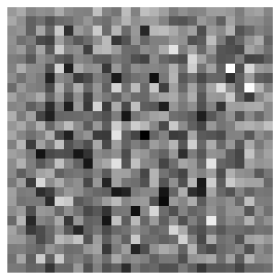

In [5]:
from matplotlib import pyplot as plt
from matplotlib.axes import Axes

def plot_generator(z: torch.Tensor, model: WGAN, ax: Optional[Axes] = None):
    z = z.to(model.device)
    with torch.no_grad():
        x = model.generator(z).view(28, 28).cpu().numpy() * 0.5 + 0.5

    if ax is None:
        plt.imshow(x, cmap='gray')
        plt.axis('off')
    else:
        ax.imshow(x, cmap='gray')
        ax.axis('off')

x_noise = torch.randn(1, 128)
plot_generator(x_noise, model)
plt.show()

WGAN-GP原论文使用Adam优化器，学习率为$5\times 10^{-4}$，每迭代5次更新一次生成器。

In [6]:
# Optimizer
optimizer_g = torch.optim.Adam(model.generator.parameters(), lr=5e-4)
optimizer_d = torch.optim.Adam(model.critic.parameters(), lr=5e-4)

# Hyper parameters
N = 100 # Number of epochs
alpha = 10 # Gradient penalty
K = 5 # Number of critic updates per generator update
device = 'cuda:5' if torch.cuda.is_available() else 'cpu' # CUDA
model.to(device)

# Use random noise to inspect training process
x_noise = torch.randn(1, 128)

# Record training metrics
step = 0
train_metrics = []

此处在训练判别器时，对于真实样本、虚拟样本和梯度惩罚三个损失函数部分分别进行优化，将结果记录到`train_metrics`中。

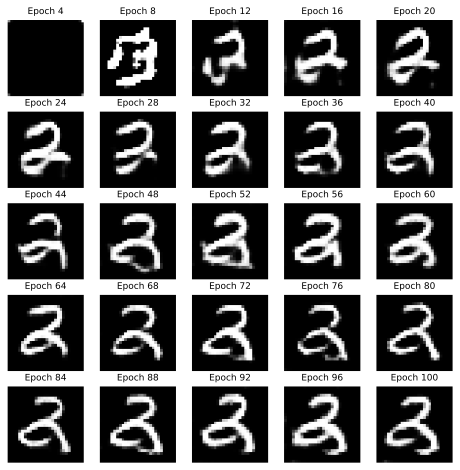

In [7]:
fig, ax = plt.subplots(5, 5, figsize=(8, 8))
axes = iter(ax.flatten())

for epoch in range(N):
    for i, (x, _) in enumerate(train_loader, start=0):
        model.train()
        step_metric = {}
        step += 1
        size = x.size(0)

        # Train critic
        # Fake sample
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        x_fake, y_fake = model(size=size)
        fake = y_fake.mean()
        fake.backward()
        step_metric['fake_score'] = fake.item()
        optimizer_d.step()

        # Real sample
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        _, y_real = model(x)
        real = -y_real.mean()
        step_metric['real_score'] = -(real.item())
        real.backward()
        optimizer_d.step()

        # Gradient penalty
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()
        penalty = model.penalty(x, x_fake).mean()
        step_metric['penalty'] = penalty.item()
        penalty = penalty * alpha
        penalty.backward()
        optimizer_d.step()

        # Train generator
        if step % K == 0:
            # Train generator
            optimizer_g.zero_grad()
            optimizer_d.zero_grad()
            x, y = model(size=size)
            loss_fake = -y.mean()
            loss_fake.backward()
            optimizer_g.step()

            step_metric['generator_score'] = -(loss_fake.item())

        train_metrics.append(step_metric)

    if (epoch + 1) % 4 == 0:
        model.eval()
        ax = next(axes)
        ax.set_title(f'Epoch {epoch + 1}', fontsize=9)
        plot_generator(x_noise, model, ax)

fig.show()

In [8]:
from typing import Any, Dict, Iterable, List, Tuple
import random

def extract_metrics(data: List[Dict[str, Any]], field: str) -> Tuple[List[int], List[Any]]:
    x, y = [], []
    for step, record in enumerate(data, start=1):
        if field in record:
            x.append(step)
            y.append(record[field])
    return x, y

def ema(x, beta):
    y = x[0]
    for _ in x:
        y = beta * y + (1 - beta) * _
        yield y

def sample(x: Iterable[Any], y: Iterable[Any], ratio: float):
    result_x, result_y = [], []
    for x_sample, y_sample in zip(x, y):
        if random.random() < ratio:
            result_x.append(x_sample)
            result_y.append(y_sample)
    return result_x, result_y

绘图展示判别器模型在真实样本和虚拟样本上的输出。两者的差值即为Wasserstein distance。通过梯度惩罚项可以看出，判别器很快即可收敛到满足1-Lipschitz的情况。

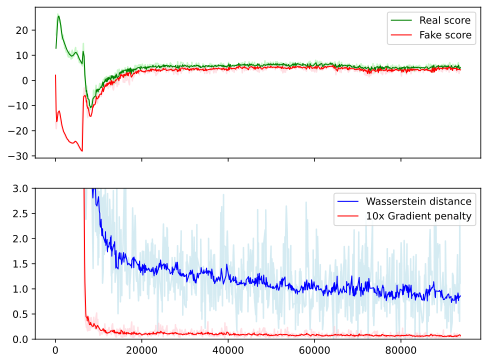

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

x_real_score, y_real_score = extract_metrics(train_metrics, 'real_score')
x_fake_score, y_fake_score = extract_metrics(train_metrics, 'fake_score')
x_penalty, y_penalty = extract_metrics(train_metrics, 'penalty')
y_penalty = [alpha * _ for _ in y_penalty]

# Wasserstein distance
x_diff, y_diff = zip(*[
    (x_real, real - fake)
    for x_real, real, x_fake, fake
        in zip(x_real_score, y_real_score, x_fake_score, y_fake_score)
    if x_real == x_fake
])

ax1.plot(*sample(x_real_score, y_real_score, 0.01), color='lightgreen', alpha=0.5)
ax1.plot(*sample(x_fake_score, y_fake_score, 0.01), color='pink', alpha=0.5)
ax2.plot(*sample(x_diff, y_diff, 0.01), color='lightblue', alpha=0.5)
ax2.plot(*sample(x_penalty, y_penalty, 0.01), color='pink', alpha=0.5)

ax1.plot(*sample(x_real_score, ema(y_real_score, 0.99), 0.01), label='Real score', color='green', linewidth=1)
ax1.plot(*sample(x_fake_score, ema(y_fake_score, 0.99), 0.01), label='Fake score', color='red', linewidth=1)
ax2.plot(*sample(x_diff, ema(y_diff, 0.99), 0.01), label='Wasserstein distance', color='blue', linewidth=1)
ax2.plot(*sample(x_diff, ema(y_penalty, 0.99), 0.01), label=f'{alpha}x Gradient penalty', color='red', linewidth=1)

ax2.set_ylim(0, 3)
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

fig.show()

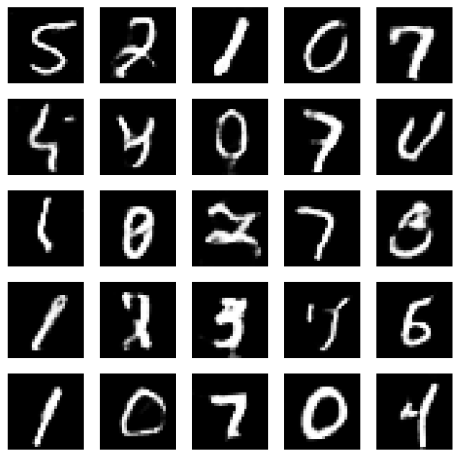

In [10]:
model.eval()
z = torch.randn(25, 128)

fig, ax = plt.subplots(5, 5, figsize=(8, 8))
for i in range(25):
    plot_generator(z[i].reshape(1, -1), model, ax[*divmod(i, 5)])

Paper reference:

* Wasserstein GAN
    ```bibtex
    @article{arjovsky2017wasserstein,
        abstract = {We introduce a new algorithm named WGAN, an alternative to traditional GAN training. In this new model, we show that we can improve the stability of learning, get rid of problems like mode collapse, and provide meaningful learning curves useful for debugging and hyperparameter searches. Furthermore, we show that the corresponding optimization problem is sound, and provide extensive theoretical work highlighting the deep connections to other distances between distributions.},
        author = {Martin Arjovsky and Soumith Chintala and L{\'e}on Bottou},
        eprint = {1701.07875},
        month = {01},
        title = {Wasserstein GAN},
        url = {https://arxiv.org/pdf/1701.07875.pdf},
        year = {2017}
    }
    ```
* Improved Training of Wasserstein GANs (WGAN-GP)
    ```bibtex
    @article{gulrajani2017improved,
        abstract = {Generative Adversarial Networks (GANs) are powerful generative models, but suffer from training instability. The recently proposed Wasserstein GAN (WGAN) makes progress toward stable training of GANs, but sometimes can still generate only low-quality samples or fail to converge. We find that these problems are often due to the use of weight clipping in WGAN to enforce a Lipschitz constraint on the critic, which can lead to undesired behavior. We propose an alternative to clipping weights: penalize the norm of gradient of the critic with respect to its input. Our proposed method performs better than standard WGAN and enables stable training of a wide variety of GAN architectures with almost no hyperparameter tuning, including 101-layer ResNets and language models over discrete data. We also achieve high quality generations on CIFAR-10 and LSUN bedrooms.},
        author = {Ishaan Gulrajani and Faruk Ahmed and Martin Arjovsky and Vincent Dumoulin and Aaron Courville},
        eprint = {1704.00028},
        month = {04},
        title = {Improved Training of Wasserstein GANs},
        url = {https://arxiv.org/pdf/1704.00028.pdf},
        year = {2017}
    }
    ```